# Import

In [0]:
import numpy as np 
import pandas as pd 
import os 
import shutil 
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/deep_learning/classification/

/content/gdrive/My Drive/deep_learning/classification


In [0]:
ls

17Flowers-GroundTruth.txt  TestSet1.txt  TrainSet1.txt  ValSet1.txt
files.txt                  TestSet2.txt  TrainSet2.txt  ValSet2.txt
jpg/                       TestSet3.txt  TrainSet3.txt  ValSet3.txt
Test/                      Train/        Valid/


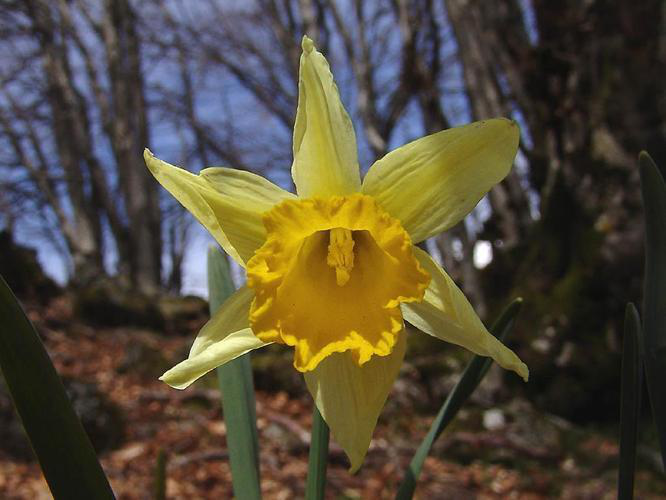

In [0]:
from PIL import Image #show one example of image
Image.open("/content/gdrive/My Drive/deep_learning/classification/jpg/image_0002.jpg")

# Dataset Preparation

In [0]:
files= pd.read_csv('files.txt', header = None)
files.columns = ['file_name']
files.head()

,file_name
0,image_0001.jpg
1,image_0002.jpg
2,image_0003.jpg
3,image_0004.jpg
4,image_0005.jpg


In [0]:
filesTrain = pd.read_csv('TrainSet1.txt', header = None)
filesTrain.columns = ['file_name']
filesTrain.head()

,file_name
0,image_0024.jpg
1,image_0031.jpg
2,image_0008.jpg
3,image_0021.jpg
4,image_0025.jpg


In [0]:
filesTest = pd.read_csv('TestSet1.txt', header = None)
filesTest.columns = ['file_name']
filesTest.head()

,file_name
0,image_0004.jpg
1,image_0028.jpg
2,image_0011.jpg
3,image_0014.jpg
4,image_0006.jpg


In [0]:
filesValid = pd.read_csv('ValSet1.txt', header = None)
filesValid.columns = ['file_name']
filesValid.head()

,file_name
0,image_0038.jpg
1,image_0003.jpg
2,image_0040.jpg
3,image_0032.jpg
4,image_0012.jpg


In [0]:
filesTrain['Train'] = 'Train'
filesTest['Test'] = 'Test'
filesValid['Valid'] = 'Valid' 

In [0]:
ground_truth = pd.read_csv('17Flowers-GroundTruth.txt')
ground_truth.head()

,FlowerName,FirstImage,LastImage
0,Daffodil,image_0001.jpg,image_0080.jpg
1,Snowdrop,image_0081.jpg,image_0160.jpg
2,LilyValley,image_0161.jpg,image_0240.jpg
3,Bluebell,image_0241.jpg,image_0320.jpg
4,Crocus,image_0321.jpg,image_0400.jpg


In [0]:
ground_truth['first_image'] = ground_truth.FirstImage.apply(lambda x: str(x).split('_')[1]).apply(lambda x: str(x).split('.')[0]).astype(int)
ground_truth['last_image'] = ground_truth.LastImage.apply(lambda x: str(x).split('_')[1]).apply(lambda x: str(x).split('.')[0]).astype(int)
ground_truth.head()

,FlowerName,FirstImage,LastImage,first_image,last_image
0,Daffodil,image_0001.jpg,image_0080.jpg,1,80
1,Snowdrop,image_0081.jpg,image_0160.jpg,81,160
2,LilyValley,image_0161.jpg,image_0240.jpg,161,240
3,Bluebell,image_0241.jpg,image_0320.jpg,241,320
4,Crocus,image_0321.jpg,image_0400.jpg,321,400


In [0]:
merged = pd.merge(files,filesTrain, how = 'left')
merged = pd.merge(merged,filesTest, how = 'left')
merged = pd.merge(merged,filesValid, how = 'left')
merged.head()

,file_name,Train,Test,Valid
0,image_0001.jpg,NaN,NaN,Valid
1,image_0002.jpg,Train,NaN,NaN
2,image_0003.jpg,NaN,NaN,Valid
3,image_0004.jpg,NaN,Test,NaN
4,image_0005.jpg,NaN,NaN,Valid


In [0]:
merged['train_test_valid'] = merged.Train.fillna(merged.Test.fillna(merged.Valid))
merged['train_test_valid']

0       Valid
1       Train
2       Valid
3        Test
4       Valid
        ...  
1355    Train
1356     Test
1357    Valid
1358    Train
1359    Valid
Name: train_test_valid, Length: 1360, dtype: object

In [0]:
merged['image_id'] = merged.file_name.apply(lambda x: str(x).split('_')[1]).apply(lambda x: str(x).split('.')[0]).astype(int)
merged['image_id']

0          1
1          2
2          3
3          4
4          5
        ... 
1355    1356
1356    1357
1357    1358
1358    1359
1359    1360
Name: image_id, Length: 1360, dtype: int64

In [0]:
import shutil

In [0]:
# execute Only execute if file alredy present
shutil.rmtree("/content/gdrive/My Drive/deep_learning/classification/Train/")
shutil.rmtree("/content/gdrive/My Drive/deep_learning/classification/Test/")
shutil.rmtree("/content/gdrive/My Drive/deep_learning/classification/Valid/")

In [0]:
pwd

'/content/gdrive/My Drive/deep_learning/classification'

In [0]:
os.mkdir("Train")
os.mkdir("Test")
os.mkdir("Valid")

In [0]:
ls

17Flowers-GroundTruth.txt  TestSet1.txt  TrainSet1.txt  ValSet1.txt
files.txt                  TestSet2.txt  TrainSet2.txt  ValSet2.txt
jpg/                       TestSet3.txt  TrainSet3.txt  ValSet3.txt
Test/                      Train/        Valid/


In [0]:
def move_file(row):
  file_name = row['file_name']
  folder_1 = row['train_test_valid']
  file_index = int(row['image_id'])
  folder_2 =   ground_truth[(ground_truth.first_image <= file_index) & (ground_truth.last_image >= file_index)].FlowerName.values[0]
  move_from = "/content/gdrive/My Drive/deep_learning/classification/jpg/" + file_name
  move_to = "/content/gdrive/My Drive/deep_learning/classification/" + folder_1 +'/'+ folder_2
  try:
    os.mkdir(folder_1 +'/'+ folder_2)
  except:
    pass

  # shutil.move(move_from, move_to)
  shutil.copy(move_from, move_to)
  # shutil.move()


merged.apply(lambda x: move_file(x), axis = 1)
print("All Done!!")

huhahahaha


In [0]:
train_dir =os.path.realpath('Train')
Test_dir = os.path.realpath('Test')
validation_dir = os.path.realpath('Valid')
image_size = 227

In [0]:
# image augmentation for train set and image resizing for validation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # this function will generate augmented images in real time
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

Test_datagen = ImageDataGenerator(rescale=1./255) # for validation we don't need to augment

train_batchsize = 100
val_batchsize = 10
 
train_generator = train_datagen.flow_from_directory( # this function takes images from folders and feeds to Imagedatagenerator
        train_dir,
        target_size=(image_size, image_size),
        batch_size= 20,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size= 20,
        class_mode='categorical',
        shuffle=False)
 
test_generator = Test_datagen.flow_from_directory(
        Test_dir,
        target_size=(image_size, image_size),
        batch_size= 20,
        class_mode='categorical',
        shuffle=False)

Found 680 images belonging to 17 classes.
Found 340 images belonging to 17 classes.
Found 340 images belonging to 17 classes.


#Model

In [0]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(96, (11,11),strides=4, padding='valid', activation='relu', input_shape=(227, 227, 3)),

    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2),padding='valid'),

    tf.keras.layers.Conv2D(256, (5,5),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2),padding='valid'),

    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.Conv2D(256, (3,3),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.Conv2D(128, (3,3),strides=1, padding='valid', activation='relu'),

    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2),padding='valid'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, activation='relu'),

    tf.keras.layers.Dense(2048, activation='relu'),

    tf.keras.layers.Dense(1024, activation='relu'),
    
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(17, activation='softmax')])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 256)         8

##Training

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=2e-4), 
              metrics=['acc'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
34/34 [==============================] - 265s 8s/step - loss: 2.8396 - acc: 0.0735 - val_loss: 2.6921 - val_acc: 0.1206
Epoch 2/100
34/34 [==============================] - 12s 366ms/step - loss: 2.6013 - acc: 0.1132 - val_loss: 2.5929 - val_acc: 0.1147
Epoch 3/100
34/34 [==============================] - 13s 369ms/step - loss: 2.5555 - acc: 0.0941 - val_loss: 2.8789 - val_acc: 0.0824
Epoch 4/100
34/34 [==============================] - 13s 374ms/step - loss: 2.5075 - acc: 0.1235 - val_loss: 2.3838 - val_acc: 0.1500
Epoch 5/100
34/34 [==============================] - 13s 376ms/step - loss: 2.4761 - acc: 0.1162 - val_loss: 2.3625 - val_acc: 0.1441
Epoch 6/100
34/34 [==============================] - 13s 371ms/step - loss: 2.4318 - acc: 0.1397 - val_loss: 2.4081 - val_acc: 0.1441
Epoch 7/100
34/34 [==============================] - 13s 374ms/step - loss: 2.4122 - acc: 0.1324 - val_loss: 2.2360 - val_

In [0]:
print('training acc.:',history.history['acc'][-1],'\n','Validation acc.:', (history.history['val_acc'])[-1])

training acc.: 0.8838235139846802 
 Validation acc.: 0.7235293984413147


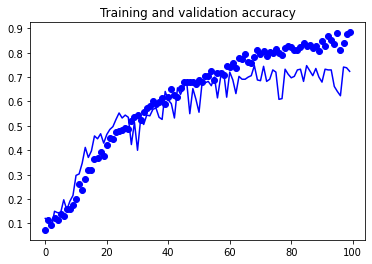

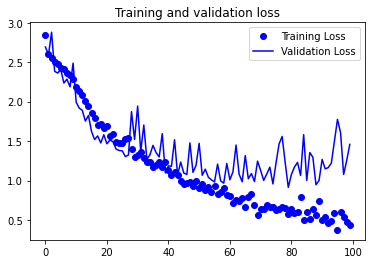

In [0]:
#Ploting History Curve
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Predictions

In [0]:
predictions = model.predict(test_generator)

In [0]:
class_name = ['Bluebell', 'Buttercup', 'ColtsFoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'LilyValley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'Tulip', 'Windflower']

In [0]:
# temp = []
labels = []
name=[]
for i in range(len(predictions)):
  predictions[i].flatten()
  index = predictions[i].argmax(axis=0)
  name.append(index)
  label = class_name[index]
  labels.append(label)


In [0]:
len(test_generator[16][0])

20

In [0]:
a= []
l=[]
for i in range(0,17):
  for j in test_generator[i][0]:
    a.append(j)
    l.append(i)

In [0]:
np.shape(a[0])

(227, 227, 3)

#Visualization

In [0]:
# Display some classification result on RAW input test samples
images_raw_ann = []
predict_label_ann_raw = []
raw = []
for i in np.random.choice(np.arange(0, len(a)), size=(50,)):
  test = l[i]
  image = a[i]
  # test = test_generator.labels[i]
  # print(i, end=" ")
  # print(test)
  predictions = labels[i]
  # image = test_generator[i][0]
  images_raw_ann.append(image)
  raw.append(class_name[test])
  predict_label_ann_raw.append(predictions)

Predicted Label: Daffodil    Actual label: Daffodil
Predicted Label: Bluebell    Actual label: Bluebell
Predicted Label: Crocus    Actual label: Crocus
Predicted Label: Tulip    Actual label: Tulip


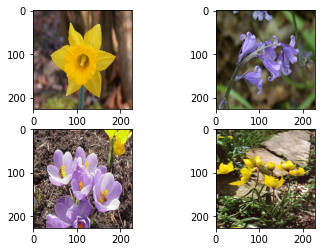

In [0]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images_raw_ann[1])
print("Predicted Label:",predict_label_ann_raw[1], end="    ")
print("Actual label:",raw[1])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images_raw_ann[2])
print("Predicted Label:",predict_label_ann_raw[2], end="    ")
print("Actual label:",raw[2])
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images_raw_ann[3])
print("Predicted Label:",predict_label_ann_raw[3], end="    ")
print("Actual label:",raw[3])
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(images_raw_ann[4])
print("Predicted Label:",predict_label_ann_raw[4], end="    ")
print("Actual label:",raw[4])

In [0]:
accuracy = metrics.accuracy_score(test_generator.labels, name)
print("Accuracy on test dataset:",accuracy)

Accuracy on test dataset: 0.7764705882352941
